In [17]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import fbeta_score, make_scorer, precision_recall_curve, auc
from xgboost.sklearn import XGBClassifier
import joblib
from modeling_helper import create_xy, search_result, get_important_feature
import matplotlib.pyplot as plt

In [2]:
flights = pd.read_csv('/Users/user/Documents/Github/flightstatus/data/dev/flights_processed.csv')

The dataset includes US flights in 2015. We will use flights 
- from January to June for training
- from July to September for validation
- October to December for test.

In [3]:
datatrain = flights[flights.MONTH<=6]
dataval = flights[(flights.MONTH>=7)&(flights.MONTH<=9)]
datatest = flights[flights.MONTH<=10]

In [4]:
X_train, y_train = create_xy(datatrain)
X_val, y_val = create_xy(dataval)
X_test, y_test = create_xy(datatest)

In [5]:
ftwo_scorer = make_scorer(fbeta_score, beta=2)

## Starting model

`scale_pos_weight` is the ratio of number of negative class to the positive class. 

In [12]:
spw = (sum(y_train==0) + sum(y_val==0))/(sum(y_train==1)+sum(y_val==1)) # 1.9
metric='aucpr'

In [13]:
m_xgb = XGBClassifier(max_depth=5,
                      min_child_weight=5,
                      subsample=0.8,
                      colsample_bytree=0.8,
                      learning_rate = 1,
                      reg_alpha = 0, reg_lambda = 0, gamma=0,
                      scale_pos_weight=spw,
                      objective= 'binary:logistic',
                      random_state=123,
                      n_jobs=-1, n_estimators = 999)

m_xgb.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], 
          eval_metric=[metric], early_stopping_rounds=5, verbose=True)

[0]	validation_0-aucpr:0.499499	validation_1-aucpr:0.46866
Multiple eval metrics have been passed: 'validation_1-aucpr' will be used for early stopping.

Will train until validation_1-aucpr hasn't improved in 5 rounds.
[1]	validation_0-aucpr:0.516719	validation_1-aucpr:0.483693
[2]	validation_0-aucpr:0.524325	validation_1-aucpr:0.483053
[3]	validation_0-aucpr:0.536689	validation_1-aucpr:0.486077
[4]	validation_0-aucpr:0.539496	validation_1-aucpr:0.486111
[5]	validation_0-aucpr:0.547487	validation_1-aucpr:0.482417
[6]	validation_0-aucpr:0.551756	validation_1-aucpr:0.486662
[7]	validation_0-aucpr:0.554639	validation_1-aucpr:0.489461
[8]	validation_0-aucpr:0.555768	validation_1-aucpr:0.490691
[9]	validation_0-aucpr:0.558394	validation_1-aucpr:0.491071
[10]	validation_0-aucpr:0.559318	validation_1-aucpr:0.490686
[11]	validation_0-aucpr:0.563541	validation_1-aucpr:0.485125
[12]	validation_0-aucpr:0.566115	validation_1-aucpr:0.487531
[13]	validation_0-aucpr:0.568793	validation_1-aucpr:0.4900

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0,
              learning_rate=1, max_delta_step=0, max_depth=5,
              min_child_weight=5, missing=None, n_estimators=999, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=123,
              reg_alpha=0, reg_lambda=0, scale_pos_weight=1.8877951200497267,
              seed=None, silent=None, subsample=0.8, verbosity=1)

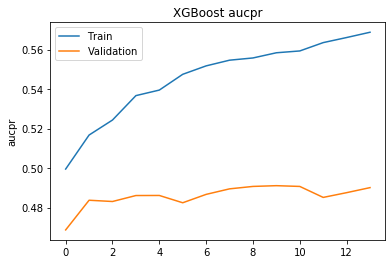

In [19]:
# retrieve performance metrics
results = m_xgb.evals_result()
epochs = len(results['validation_0'][metric])
x_axis = range(0, epochs)
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0'][metric], label='Train')
ax.plot(x_axis, results['validation_1'][metric], label='Validation')
ax.legend()
plt.ylabel(metric)
plt.title('XGBoost '+metric)
plt.show()

## Hyperparameter Tuning: Random Search

In [22]:
parameter_grid = {
    'max_depth' : list(range(3,6)), 
    'min_child_weight': list(range(2,7)),
    'subsample' : [i/10.0 for i in range(8, 10)], 
    'colsample_bytree' : [i/10.0 for i in range(8, 10)],
    'learning_rate' : np.linspace(0.5,2,5)
}

number_models = 5
random_XGB_class = RandomizedSearchCV(estimator = XGBClassifier(max_depth=5,
                                      min_child_weight=5,
                                      subsample=0.8,
                                      colsample_bytree=0.8,
                                      learning_rate = 1,
                                      reg_alpha = 0, reg_lambda = 0, gamma=0,
                                      scale_pos_weight=spw,
                                      objective= 'binary:logistic',
                                      random_state=123,
                                      n_jobs=-1, n_estimators = 999), 
                                      
                                      param_distributions = parameter_grid, n_iter = number_models, 
                                      scoring='average_precision', cv = 10, return_train_score = False,
                                      n_jobs=-1)
random_XGB_class.fit(X_train, y_train, eval_set= [(X_val, y_val)], eval_metric=metric, early_stopping_rounds=5)

[0]	validation_0-aucpr:0.449992
Will train until validation_0-aucpr hasn't improved in 5 rounds.
[1]	validation_0-aucpr:0.43587
[2]	validation_0-aucpr:0.451038
[3]	validation_0-aucpr:0.463404
[4]	validation_0-aucpr:0.458177
[5]	validation_0-aucpr:0.462092
[6]	validation_0-aucpr:0.471135
[7]	validation_0-aucpr:0.455461
[8]	validation_0-aucpr:0.457856
[9]	validation_0-aucpr:0.459778
[10]	validation_0-aucpr:0.459502
[11]	validation_0-aucpr:0.457401
Stopping. Best iteration:
[6]	validation_0-aucpr:0.471135



RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=0.8, gamma=0,
                                           learning_rate=1, max_delta_step=0,
                                           max_depth=5, min_child_weight=5,
                                           missing=None, n_estimators=999,
                                           n_jobs=-1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=123, reg_alpha=0,
                                           reg_lambda=...
                                           subsample=0.8, verbosity=1),
                   iid='deprecated', n_iter=5, n_jobs=-1,
                   param_distributions={'colsamp

In [23]:
rs_result = search_result(random_XGB_class)
rs_result

,subsample,min_child_weight,max_depth,learning_rate,colsample_bytree,mean_score,std_score
2,0.8,6,3,1.625,0.9,0.452064,0.035071
4,0.9,6,4,0.875,0.9,0.428589,0.067398
3,0.8,3,4,0.875,0.9,0.426026,0.061418
0,0.9,4,3,0.875,0.8,0.421398,0.052723
1,0.9,3,5,1.250,0.9,0.405512,0.060550


## Hyperparameter Tuning: Grid Search

In [25]:
parameter_grid = {
    'max_depth' : [3, 4, 5], 
    'learning_rate' : [1.0, 1.5]
}

grid_XGB_class = GridSearchCV(estimator = XGBClassifier(max_depth=5,
                                      min_child_weight=5,
                                      subsample=0.8,
                                      colsample_bytree=0.8,
                                      learning_rate = 1,
                                      reg_alpha = 0, reg_lambda = 0, gamma=0,
                                      scale_pos_weight=spw,
                                      objective= 'binary:logistic',
                                      random_state=123,
                                      n_jobs=-1, n_estimators = 999),
                                                        
                                      param_grid = parameter_grid, 
                                      scoring='average_precision', cv = 10, return_train_score = False,
                                      n_jobs=-1)
grid_XGB_class.fit(X_train, y_train, eval_set= [(X_val, y_val)], eval_metric=metric, early_stopping_rounds=5)

[0]	validation_0-aucpr:0.449992
Will train until validation_0-aucpr hasn't improved in 5 rounds.
[1]	validation_0-aucpr:0.442973
[2]	validation_0-aucpr:0.450722
[3]	validation_0-aucpr:0.447204
[4]	validation_0-aucpr:0.462898
[5]	validation_0-aucpr:0.461719
[6]	validation_0-aucpr:0.465116
[7]	validation_0-aucpr:0.462842
[8]	validation_0-aucpr:0.465202
[9]	validation_0-aucpr:0.463726
[10]	validation_0-aucpr:0.464053
[11]	validation_0-aucpr:0.46357
[12]	validation_0-aucpr:0.464984
[13]	validation_0-aucpr:0.469835
[14]	validation_0-aucpr:0.467747
[15]	validation_0-aucpr:0.46347
[16]	validation_0-aucpr:0.465378
[17]	validation_0-aucpr:0.471766
[18]	validation_0-aucpr:0.473913
[19]	validation_0-aucpr:0.468671
[20]	validation_0-aucpr:0.471647
[21]	validation_0-aucpr:0.472408
[22]	validation_0-aucpr:0.472931
[23]	validation_0-aucpr:0.474577
[24]	validation_0-aucpr:0.478664
[25]	validation_0-aucpr:0.479537
[26]	validation_0-aucpr:0.475672
[27]	validation_0-aucpr:0.477369
[28]	validation_0-aucpr

GridSearchCV(cv=10, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.8, gamma=0,
                                     learning_rate=1, max_delta_step=0,
                                     max_depth=5, min_child_weight=5,
                                     missing=None, n_estimators=999, n_jobs=-1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=123, reg_alpha=0,
                                     reg_lambda=0,
                                     scale_pos_weight=1.8877951200497267,
                                     seed=None, silent=None, subsample=0.8,
                                     verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'learning_rate': [1.0, 1.5], 'max_depth': [3, 4, 5]},
   

In [26]:
grid_XGB_class.best_estimator_.get_params

<bound method XGBModel.get_params of XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0,
              learning_rate=1.5, max_delta_step=0, max_depth=3,
              min_child_weight=5, missing=None, n_estimators=999, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=123,
              reg_alpha=0, reg_lambda=0, scale_pos_weight=1.8877951200497267,
              seed=None, silent=None, subsample=0.8, verbosity=1)>

In [27]:
joblib.dump(grid_XGB_class, 'grid_XGB_class')
# grid_XGB_class = joblib.load('grid_XGB_class')

['grid_XGB_class']

In [28]:
gs = search_result(grid_XGB_class)
gs

,learning_rate,max_depth,mean_score,std_score
3,1.5,3,0.453492,0.037809
5,1.5,5,0.448990,0.032411
1,1.0,4,0.446787,0.056759
0,1.0,3,0.443686,0.036347
4,1.5,4,0.435008,0.061617
2,1.0,5,0.432688,0.054995


### Get feature importance

In [30]:
imp_feat = get_important_feature(X_train.columns, grid_XGB_class.best_estimator_.feature_importances_)
imp_feat

,feature,importance_score
7,SCHEDULED_ARRIVAL,0.191419
23,AIRLINE_CAT,0.074473
15,MONTH_TRAFFIC,0.069163
24,TAIL_NUMBER_CAT,0.054796
1,DAY,0.052258
17,ORIGIN_AIRPORT_TRAFFIC,0.048312
21,LONGITUDE_DIF,0.046650
16,AIRLINE_TRAFFIC,0.044344
9,LONGITUDE_ORIGIN,0.041617
2,DAY_OF_WEEK,0.039831


## Final model 
- with important features only
- it can be a loop

In [36]:
final_feat = imp_feat.loc[imp_feat['importance_score']>0, 'feature'].tolist()
len(final_feat)

17

In [37]:
X_train_new = X_train[final_feat]
X_val_new = X_val[final_feat]
X_test_new = X_test[final_feat]

In [38]:
m_xgb = XGBClassifier(max_depth=3,
                      min_child_weight=5,
                      subsample=0.8,
                      colsample_bytree=0.8,
                      learning_rate = 1.5,
                      reg_alpha = 0, reg_lambda = 0, gamma=0,
                      objective= 'binary:logistic',
                      random_state=123,
                      n_jobs=-1, n_estimators = 999)

m_xgb.fit(X_train_new, y_train, eval_set=[(X_train_new, y_train), (X_val_new, y_val)], 
          eval_metric=metric, early_stopping_rounds=5, verbose=True)

[0]	validation_0-aucpr:0.474375	validation_1-aucpr:0.440825
Multiple eval metrics have been passed: 'validation_1-aucpr' will be used for early stopping.

Will train until validation_1-aucpr hasn't improved in 5 rounds.
[1]	validation_0-aucpr:0.483529	validation_1-aucpr:0.443526
[2]	validation_0-aucpr:0.501333	validation_1-aucpr:0.46886
[3]	validation_0-aucpr:0.508626	validation_1-aucpr:0.477173
[4]	validation_0-aucpr:0.515974	validation_1-aucpr:0.478062
[5]	validation_0-aucpr:0.520197	validation_1-aucpr:0.481458
[6]	validation_0-aucpr:0.52178	validation_1-aucpr:0.482108
[7]	validation_0-aucpr:0.523852	validation_1-aucpr:0.485119
[8]	validation_0-aucpr:0.527732	validation_1-aucpr:0.485921
[9]	validation_0-aucpr:0.53267	validation_1-aucpr:0.485506
[10]	validation_0-aucpr:0.53287	validation_1-aucpr:0.485623
[11]	validation_0-aucpr:0.536214	validation_1-aucpr:0.486768
[12]	validation_0-aucpr:0.536687	validation_1-aucpr:0.485945
[13]	validation_0-aucpr:0.5377	validation_1-aucpr:0.483774
[1

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0,
              learning_rate=1.5, max_delta_step=0, max_depth=3,
              min_child_weight=5, missing=None, n_estimators=999, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=123,
              reg_alpha=0, reg_lambda=0, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8, verbosity=1)

In [39]:
imp_feat = get_important_feature(X_train_new.columns, m_xgb.feature_importances_)
imp_feat

,feature,importance_score
0,SCHEDULED_DEPARTURE,0.216075
3,AIRLINE_TRAFFIC,0.096657
2,AIRLINE_CAT,0.095982
6,SCHEDULED_TIME,0.089969
1,TAIL_NUMBER_CAT,0.084002
11,MONTH,0.053548
10,ORIGIN_AIRPORT_TRAFFIC,0.043240
9,LONGITUDE_ORIGIN,0.042855
7,DATE_TRAFFIC,0.041202
16,LONGITUDE_DESTINATION,0.039844


If we still see some variables with zero important score, remove them and retrain the model.

### Make predictions

In [40]:
y_train_prob = m_xgb.predict_proba(X_train_new)[:,1]
y_val_prob = m_xgb.predict_proba(X_val_new)[:,1]
y_test_prob = m_xgb.predict_proba(X_test_new)[:,1]

### Get Precision-Recall AUC

In [41]:
precision, recall, thresholds = precision_recall_curve(y_train, y_train_prob)
auc(recall, precision)

0.5392735036298114

In [42]:
precision, recall, thresholds = precision_recall_curve(y_val, y_val_prob)
auc(recall, precision)

0.48687715787870856

In [43]:
precision, recall, thresholds = precision_recall_curve(y_test, y_test_prob)
auc(recall, precision)

0.5202309334114632